In [112]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import pickle

# ML imports
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
from scipy import optimize, linalg
import scipy
from sklearn.model_selection import KFold # import KFold

# custom imports
import encoding_tools as encoding
import chimera_tools as chimera
import GP_tools as GP

# import scipy
import seaborn as sns

# define plotting settings
sns.set_context("paper")
sns.set_style("white")

# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({u'axes.titlesize': 16})
sns.color_palette('colorblind')
plt.close('all')

## Load model inputs

In [120]:
# load contact information
path_inputs = 'inputs/'
path_outputs = 'outputs/'
fname_1 = path_inputs + 'lit_alignment_and_contacts_pro2.pkl'

# load the contact map
with open(fname_1, 'rb') as f:
    ss, contacts = pickle.load(f)
    
# only use the first three parents
ss = [i[0:3] for i in ss]

# load ephys data
df_input = pd.read_csv(path_inputs+'Ephys_data_formatted.csv')

# load library files
file_c = path_inputs + 'shmetis_c_10_21_0/chimeras.output'
file_n = path_inputs + 'shmetis_n_10_21_0/chimeras.output'

# add sequence information to dataframe based on chimera code
df_input = chimera.chimera_code2seq_convert(file_c,file_n,df_input)

## Data formating

In [114]:
def data_format(property_, df):
    # test data only includes gen 10
    df_test_data = df[df.gen == 10]

    # remove ChR_29_10 & ChR_30_10 for kinetics and spectra because currents too low for accurate measurements
    if property_ == 'green_norm' or property_ == 'kinetics_off':
        df_test_data = df_test_data[df_test_data.chimera != 'ChR_29_10']
        df_test_data = df_test_data[df_test_data.chimera != 'ChR_30_10']

    # training data excludes test data (gen 10)
    df_data = df[df.gen != 10]

    # make a seperate dataframe for the selected property
    df_select = pd.DataFrame()
    df_select['prop'] = df_data[str(property_)]
    df_select['seq'] = df_data['seq']
    df_select['block_k'] = df_data['block_k']
    df_select['chimera'] = df_data['chimera']
    df_select.dropna(inplace=True)

    # normalize training data
    log_data = np.log(df_select.prop.values)
    y = (log_data - np.mean(log_data))/np.std(log_data)
    seq = df_select.seq.values

    # make a seperate dataframe for the selected property for test set
    df_select_test = pd.DataFrame()
    df_select_test['prop'] = df_test_data[str(property_)]
    df_select_test['seq'] = df_test_data['seq']
    df_select_test['block_k'] = df_test_data['block_k']
    df_select_test['chimera'] = df_test_data['chimera']
    df_select_test.dropna(inplace=True)

    # normalize test data
    log_data_test = np.log(df_select_test.prop.values)
    y_true_test = (log_data_test - np.mean(log_data))/np.std(log_data)
    seq_test = df_select_test.seq.values
    return log_data, y, seq, y_true_test, seq_test, df_select, df_select_test

## Encodings

In [115]:
def encoding_inputs(df_select, df_select_test, ss, contacts):
    # one_hot_encode based on sequence & structure
    X = encoding.one_hot_(df_select['seq'].values, ss, contacts)
    X = np.array(X)

    # also encode the test sequences
    X_true_test = encoding.one_hot_(df_select_test['seq'].values, ss, contacts)
    X_true_test = np.array(X_true_test)
    
    return X, X_true_test

## Train on split training data

In [116]:
def cross_validation(X, log_data, property_):
    kf = KFold(n_splits=20) # Define the split
    kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

    mu_s = []
    var_s = []
    y_s = []
    prams_test2 = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]

        log_data_train, log_data_test = log_data[train_index], log_data[test_index]

        y_train = (log_data_train - np.mean(log_data_train))/np.std(log_data_train)
        y_test = (log_data_test - np.mean(log_data_train))/np.std(log_data_train)

        initial_guess = [0.1,10]

        # take the log of the initial guess for optimiziation 
        initial_guess_log = np.log(initial_guess)

        # optimize to fit model
        result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X_train,y_train), method='L-BFGS-B')#,

        # next set of hyper prams 
        prams_me = [np.exp(result.x[0])**2, np.exp(result.x[1])]

        # next used trained GP model to predict on test data
        mu, var = GP.predict_GP(X_train, y_train, X_test, prams_me)
        mu_s.append(mu)
        var_s.append(var)
        y_s.append(y_test)

    # reformat all
    y_s_all = [j for i in y_s for j in i]
    mu_s_all = [j for i in mu_s for j in i]

    # plot results
    plt.figure('My GP test set evaluation2', figsize=(2, 2))
    plt.title(str(property_))
    plt.plot(y_s_all, mu_s_all, 'o', color='k', ms=3)
    plt.ylim([-1.5, 1.5])
    plt.xlim([-2, 2])

    # calc correlation 
    measured = y_s_all
    predicted = mu_s_all

    par = np.polyfit(measured, predicted, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]

    # calc correlation 
    variance = np.var(predicted)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(measured, predicted)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    
    print('20-fold corss validation of GP regression model')
    #print('R^2 = %0.2f'% Rsqr)
    print('R = %0.2f'% np.sqrt(Rsqr))

    plt.plot([-2, 2], [slope*-2+intercept, slope*2+intercept], '-', color='k')
    plt.savefig(path_outputs + str(property_)+'_matern_kernel_CV.pdf', bbox_inches='tight', transparent=True)
    plt.show()
    return


## Evaluate on whole training set

In [121]:
def ML_train(X, y):
    # test the optimization of the hyp-prams
    initial_guess = [0.01,10]

    # take the log of the initial guess for optimiziation 
    initial_guess_log = np.log(initial_guess)

    # optimize to fit model
    result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X,y), method='L-BFGS-B')#,
                                        #bounds=bnds)
    print('Full GP regression model')
    print('Hyperparameters: ' + str(np.exp(result.x[0])) + ' ' + str(np.exp(result.x)[1]))

    # next set of hyper prams 
    final_prams = [np.exp(result.x[0])**2, np.exp(result.x[1])]
    
    return final_prams
    
def ML_predict(X, y, X_true_test, y_true_test, log_data, final_prams, property_):
    # next use trained GP model to predict full test set
    mu, var = GP.predict_GP(X, y, X, final_prams)
    mu_true_test, var_true_test = GP.predict_GP(X, y, X_true_test, final_prams)

    # convert the true test predications and y back to unnormalized data
    y_test_real = np.exp(y_true_test*np.std(log_data)  + np.mean(log_data))
    mu_test_real = np.exp(mu_true_test*np.std(log_data)  + np.mean(log_data))

    if property_ != 'kinetics_off':
        # plot and measure correlation
        plt.figure('True test', figsize=(2, 2))
        plt.plot(y_test_real, mu_test_real, 'o', color='k')
        plt.title(str(property_))
        par = np.polyfit(y_test_real, mu_test_real, 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        max_x = np.max(y_test_real)
        plt.plot([0, max_x], [intercept, slope*max_x+intercept], '-', color='k')
        plt.savefig(path_outputs + str(property_)+'_matern_kernel.pdf', bbox_inches='tight', transparent=True)
        plt.show()

        # coefficient of determination, plot text
        variance = np.var(mu_test_real)
        residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(y_test_real, mu_test_real)])
        Rsqr = np.round(1-residuals/variance, decimals=2)
        print('GP regression model test set')
        #print('R^2 = %0.2f'% Rsqr)
        print('R = %0.2f'% np.sqrt(Rsqr))

    elif property_ == 'kinetics_off':
        # plot and measure correlation
        plt.figure('True test', figsize=(2, 2))
        plt.plot(y_test_real, mu_test_real, 'o', color='k')
        plt.title(str(property_))
        par = np.polyfit(y_test_real, mu_test_real, 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        max_x = np.max(y_test_real)
        plt.plot([0, max_x], [intercept, slope*max_x+intercept], '-', color='k')
        plt.savefig(path_outputs + str(property_)+'_matern_kernel.pdf', bbox_inches='tight', transparent=True)
        plt.show()

        # coefficient of determination, plot text
        variance = np.var(np.log10(mu_test_real))
        residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(np.log10(y_test_real), np.log10(mu_test_real))])
        Rsqr = np.round(1-residuals/variance, decimals=2)
        print('GP regression model test set')
        #print('R^2 = %0.2f'% Rsqr)
        print('R = %0.2f'% np.sqrt(Rsqr))

    # export csv with predicted values
    df_select_test['y'] = y_true_test
    df_select_test['mu'] = mu_true_test
    df_select_test['y_real'] = y_test_real
    df_select_test['mu_real'] = mu_test_real

    df_select_test.to_csv(path_outputs+ '/matern_kernel_gen10_'+str(property_)+'.csv')
    return

# Train models are different properties 

### Max_peak

20-fold corss validation of GP regression model
R = 0.77


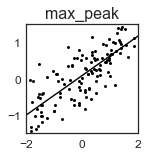

Full GP regression model
Hyperparameters: 0.0486630458398 19.662133527


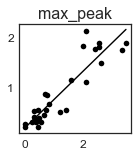

GP regression model test set
R = 0.92


In [122]:
# select the property of interest
property_ = 'max_peak'
# format data for property 
log_data, y, seq, y_true_test, seq_test, df_select, df_select_test = data_format(property_, df_input)
# encode sequences
X, X_true_test = encoding_inputs(df_select, df_select_test, ss, contacts)
# train and CV model
cross_validation(X, log_data, property_)
# train model on whole test set
final_prams = ML_train(X, y)
# use model to predict on test set and evaluate accuracy
ML_predict(X, y, X_true_test, y_true_test, log_data, final_prams, property_)

### Norm_green

20-fold corss validation of GP regression model
R = 0.89


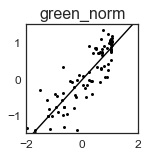

Full GP regression model
Hyperparameters: 0.104064852131 38.5362684851


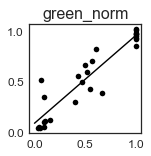

GP regression model test set
R = 0.93


In [125]:
# select the property of interest
property_ = 'green_norm'
# format data for property 
log_data, y, seq, y_true_test, seq_test, df_select, df_select_test = data_format(property_, df_input)
# encode sequences
X, X_true_test = encoding_inputs(df_select, df_select_test, ss, contacts)
# train and CV model
cross_validation(X, log_data, property_)
# train model on whole test set
final_prams = ML_train(X, y)
# use model to predict on test set and evaluate accuracy
ML_predict(X, y, X_true_test, y_true_test, log_data, final_prams, property_)

### Kinetics_off

20-fold corss validation of GP regression model
R = 0.79


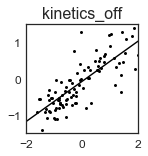

Full GP regression model
Hyperparameters: 0.0127677282727 19.1798479389


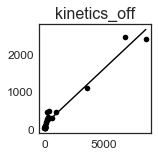

GP regression model test set
R = 0.79


In [126]:
# select the property of interest
property_ = 'kinetics_off'
# format data for property 
log_data, y, seq, y_true_test, seq_test, df_select, df_select_test = data_format(property_, df_input)
# encode sequences
X, X_true_test = encoding_inputs(df_select, df_select_test, ss, contacts)
# train and CV model
cross_validation(X, log_data, property_)
# train model on whole test set
final_prams = ML_train(X, y)
# use model to predict on test set and evaluate accuracy
ML_predict(X, y, X_true_test, y_true_test, log_data, final_prams, property_)